# Thai Named Entity Recognition Using Bi-LSTM + CRF
## The model use Bi-directional LSTM with Word / Character representation and CRF for sequece tagging

perform keras backend

- Word Embedding : v. 0.32 Thai2Fit 400 dimension
- Char Embedding : Bi-LSTM training from scratch 32 dimension

## Declare Path for Model and Dataset
Declare user path to load/save model and dataset
In this file include:
- raw path
- model path
- word embedding path
- dictionary path (char2index / ner2index)

In [1]:
DATA_PATH='./'
RAW_PATH = f'{DATA_PATH}raw/'
MODEL_PATH = f'{DATA_PATH}model/Keras/WordCharModel/'
W_MODEL_PATH = f'{DATA_PATH}model/thai2fit/'
Dict_MODEL_PATH = f'{DATA_PATH}model/dictionary/'

# Version

Keras 2.1.6 (pip install keras==2.1.6)

Python 3.5.2

In [2]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.1.6


# Import Library

In [3]:
# Save / Load File
import dill
import pickle

# Plot Graph
import matplotlib.pyplot as plt

# Sklearn Report
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from itertools import chain

# Load Vectors
from gensim.models import KeyedVectors

# Utility
import numpy as np
import time

# Model Utility
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

# Keras Model
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.utils import to_categorical
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

## Load raw dataset (NER)
load dataset that contain word and ner pair (sequence tagging) 

then split train / test dataset via train_test_split (80:20 and fix random seed for reproduction)

the train / test sentence will be result as shown below

In [4]:
with open(RAW_PATH + 'datatrain.data', 'rb') as file:
    datatofile = dill.load(file)
    
tagged_sents = []
for i in datatofile:
    text_inside = []
    for j in i:
        text_inside.append((j[0],j[2]))
    tagged_sents.append(text_inside)
    
train_sents, test_sents= train_test_split(tagged_sents, test_size=0.2, random_state=112)
print(len(train_sents))
print(len(test_sents))
print(train_sents[20])

4918
1230
[('นาย', 'B-PERSON'), ('พิเชฐ', 'I-PERSON'), (' ', 'I-PERSON'), ('ดุ', 'I-PERSON'), ('รง', 'I-PERSON'), ('ค', 'I-PERSON'), ('เวโรจน์', 'I-PERSON'), (' ', 'O'), ('รัฐมนตรี', 'O'), ('ว่า', 'O'), ('กระทรวง', 'B-ORGANIZATION'), ('ดิจิทัล', 'I-ORGANIZATION'), ('เพื่อ', 'I-ORGANIZATION'), ('เศรษฐกิจ', 'I-ORGANIZATION'), ('และ', 'I-ORGANIZATION'), ('สังคม', 'I-ORGANIZATION'), (' ', 'O'), ('(', 'O'), ('ดี', 'B-ORGANIZATION'), ('อี', 'I-ORGANIZATION'), (')', 'O'), (' ', 'O'), ('เป็น', 'O'), ('ประธาน', 'O'), ('ประชุม', 'O'), ('กลุ่มย่อย', 'O'), ('เพื่อ', 'O'), ('ร่วมกัน', 'O'), ('หารือ', 'O'), ('ใน', 'O'), ('การ', 'O'), ('ทำ', 'O'), ('บิ๊ก', 'O'), (' ', 'O'), ('ดา', 'O'), ('ต้า', 'O'), ('ของ', 'O'), ('รัฐ', 'O'), ('โดย', 'O'), ('เชิญ', 'O'), ('หน่วยราชการ', 'O'), (' ', 'O'), ('20', 'O'), (' ', 'O'), ('องค์กร', 'O'), ('มา', 'O'), ('ประชุม', 'O'), ('ร่วมกัน', 'O'), (' ', 'O'), ('โดย', 'O'), ('นาย', 'B-PERSON'), ('พิเชฐ', 'I-PERSON'), ('กล่าวว่า', 'O'), (' ', 'O'), ('นายกรัฐมนตรี', 'O'), 

## Load Thai2Fit Word Embedding
load Binary file of thai2fit (0.32) train wikipedia using ULMFit model

the word vector size is 55677x400 dimensions

credit: https://github.com/cstorm125/thai2fit

In [5]:
thai2fit_model = KeyedVectors.load_word2vec_format(W_MODEL_PATH+'thai2vecNoSym.bin',binary=True)
thai2fit_weight = thai2fit_model.vectors

## Preprocess Word
this process will index word/NER and making a dictionary of all word

set unknown and pad (Padding)

** UNKNOWN word will be replace as ("unknown") **

In [6]:
word_list=[]
ner_list=[]
thai2dict = {}

for sent in train_sents:
    for word in sent:
        word_list.append(word[0])
        ner_list.append(word[1])
        
for word in thai2fit_model.index2word:
    thai2dict[word] = thai2fit_model[word]

word_list.append("pad")
word_list.append("unknown") #Special Token for Unknown words ("UNK")
ner_list.append("pad")

all_words = sorted(set(word_list))
all_ner = sorted(set(ner_list))
all_thai2dict = sorted(set(thai2dict))

word_to_ix = dict((c, i) for i, c in enumerate(all_words)) #convert word to index 
ner_to_ix = dict((c, i) for i, c in enumerate(all_ner)) #convert ner to index
thai2dict_to_ix = dict((c, i) for i, c in enumerate(thai2dict)) #convert thai2fit to index 

ix_to_word = dict((v,k) for k,v in word_to_ix.items()) #convert index to word
ix_to_ner = dict((v,k) for k,v in ner_to_ix.items())  #convert index to ner
ix_to_thai2dict = dict((v,k) for k,v in thai2dict_to_ix.items())  #convert index to thai2fit

n_word = len(word_to_ix)
n_tag = len(ner_to_ix)
n_thai2dict = len(thai2dict_to_ix)
print(n_word)
print(n_tag)
print(n_thai2dict)
print(ner_to_ix)

13084
27
55677
{'B-DATE': 0, 'B-EMAIL': 1, 'B-LAW': 2, 'B-LEN': 3, 'B-LOCATION': 4, 'B-MONEY': 5, 'B-ORGANIZATION': 6, 'B-PERCENT': 7, 'B-PERSON': 8, 'B-PHONE': 9, 'B-TIME': 10, 'B-URL': 11, 'B-ZIP': 12, 'I-DATE': 13, 'I-EMAIL': 14, 'I-LAW': 15, 'I-LEN': 16, 'I-LOCATION': 17, 'I-MONEY': 18, 'I-ORGANIZATION': 19, 'I-PERCENT': 20, 'I-PERSON': 21, 'I-PHONE': 22, 'I-TIME': 23, 'I-URL': 24, 'O': 25, 'pad': 26}


## Preprocess Character

In [7]:
chars = set([w_i for w in thai2dict for w_i in w])
char2idx = {c: i + 5 for i, c in enumerate(chars)}

char2idx["pad"] = 0
char2idx["unknown"] = 1
char2idx[" "] = 2

char2idx["$"] = 3
char2idx["#"] = 4
char2idx["!"] = 5
char2idx["%"] = 6
char2idx["&"] = 7
char2idx["*"] = 8
char2idx["+"] = 9
char2idx[","] = 10
char2idx["-"] = 11
char2idx["."] = 12
char2idx["/"] = 13
char2idx[":"] = 14
char2idx[";"] = 15
char2idx["?"] = 16
char2idx["@"] = 17
char2idx["^"] = 18
char2idx["_"] = 19
char2idx["`"] = 20
char2idx["="] = 21
char2idx["|"] = 22
char2idx["~"] = 23
char2idx["'"] = 24
char2idx['"'] = 25

char2idx["("] = 26
char2idx[")"] = 27
char2idx["{"] = 28
char2idx["}"] = 29
char2idx["<"] = 30
char2idx[">"] = 31
char2idx["["] = 32
char2idx["]"] = 33

n_chars = len(char2idx)
print(n_chars)

399


## Save Dictionary for Character and NER

In [8]:
with open(Dict_MODEL_PATH+'chardict.pickle', 'wb') as chardict:
    pickle.dump(char2idx, chardict)

In [9]:
with open(Dict_MODEL_PATH+'nerdict.pickle', 'wb') as nerdict:
    pickle.dump(ner_to_ix, nerdict)

# Set Parameter and Hyper Parameter

In [10]:
max_len = 250
max_len_char = 30

character_LSTM_unit = 32
char_embedding_dim = 32
main_lstm_unit = 256 ## Bidirectional 256 + 256 = 512
lstm_recurrent_dropout = 0.5

train_batch_size = 32
train_epochs = 50

## Mapping Function 

In [11]:
def prepare_sequence_word(input_text):
    idxs = list()
    for word in input_text:
        if word in thai2dict:
            idxs.append(thai2dict_to_ix[word])
        else:
            idxs.append(thai2dict_to_ix["unknown"]) #Use UNK tag for unknown word
    return idxs

def prepare_sequence_target(input_label):
    idxs = [ner_to_ix[w] for w in input_label]
    return idxs

### Split word and label

In [12]:
input_sent =[ [ word[0] for word in sent]for sent in train_sents ] #words only
train_targets =[ [ word[1] for word in sent]for sent in train_sents ] #NER only

input_test_sent =[ [ word[0] for word in sent]for sent in test_sents ] #words only
test_targets =[ [ word[1] for word in sent]for sent in test_sents ] #NER only

## Prepare Training Dataset

In [13]:
## Word Training
X_word_tr = [prepare_sequence_word(s) for s in input_sent]
X_word_tr = pad_sequences(maxlen=max_len, sequences=X_word_tr, value=thai2dict_to_ix["pad"], padding='post', truncating='post')

## Character Training
X_char_tr = []
for sentence in train_sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))
        sent_seq.append(word_seq)
    X_char_tr.append(np.array(sent_seq))

## Sequence Label Training
y_tr = [prepare_sequence_target(s) for s in train_targets]
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, value=ner_to_ix["pad"], padding='post', truncating='post')
y_tr = [to_categorical(i, num_classes=n_tag) for i in y_tr]

## Prepare Testing Dataset

In [14]:
## Word Testing
X_word_te = [prepare_sequence_word(s) for s in input_test_sent]
X_word_te = pad_sequences(maxlen=max_len, sequences=X_word_te, value=thai2dict_to_ix["pad"], padding='post', truncating='post')

## Character Testing
X_char_te = []
for sentence in test_sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))    
        sent_seq.append(word_seq)
    X_char_te.append(np.array(sent_seq))

## Sequence Label Testing
y_te = [prepare_sequence_target(s) for s in test_targets]
y_te = pad_sequences(maxlen=max_len, sequences=y_te, value=ner_to_ix["pad"], padding='post', truncating='post')
y_te = [to_categorical(i, num_classes=n_tag) for i in y_te]

# Initial Keras Model

In [15]:
# Word Input
word_in = Input(shape=(max_len,), name='word_input_')

# Word Embedding Using Thai2Fit
word_embeddings = Embedding(input_dim=n_thai2dict,
                            output_dim=400,
                            weights = [thai2fit_weight],input_length=max_len,
                            mask_zero=False,
                            name='word_embedding', trainable=False)(word_in)

# Character Input
char_in = Input(shape=(max_len, max_len_char,), name='char_input')

# Character Embedding
emb_char = TimeDistributed(Embedding(input_dim=n_chars, output_dim=char_embedding_dim, 
                           input_length=max_len_char, mask_zero=False))(char_in)

# Character Sequence to Vector via BiLSTM
char_enc = TimeDistributed(Bidirectional(LSTM(units=character_LSTM_unit, return_sequences=False, recurrent_dropout=lstm_recurrent_dropout)))(emb_char)


# Concatenate All Embedding
all_word_embeddings = concatenate([word_embeddings, char_enc])
all_word_embeddings = SpatialDropout1D(0.3)(all_word_embeddings)

# Main Model BiLSTM
main_lstm = Bidirectional(LSTM(units=main_lstm_unit, return_sequences=True,
                               recurrent_dropout=lstm_recurrent_dropout))(all_word_embeddings)
main_lstm = TimeDistributed(Dense(50, activation="relu"))(main_lstm)

# CRF
crf = CRF(n_tag)  # CRF layer
out = crf(main_lstm)  # output

# Model
model = Model([word_in, char_in], out)

model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/suphanut_thattinaphanich/anaconda3/envs/ulmfit_venv/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/home/suphanut_thattinaphanich/anaconda3/envs/ulmfit_venv/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 250, 30)      0                                            
__________________________________________________________________________________________________
word_input_ (InputLayer)        (None, 250)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 250, 30, 32)  12768       char_input[0][0]                 
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 250, 400)     22270800    word_input_[0][0]                
__________________________________________________________________________________________________
time_distr

# Training Model

save best model 

In [ ]:
filepath=MODEL_PATH+"weights-improvement-{epoch:02d}-{val_crf_viterbi_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_crf_viterbi_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))
                     ],
                     np.array(y_tr),
                     batch_size=train_batch_size, epochs=train_epochs, verbose=1,callbacks=callbacks_list,
                     validation_data=(
                     [X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))
                     ],
                     np.array(y_te))
                   )

Instructions for updating:
Use tf.cast instead.
Train on 4918 samples, validate on 1230 samples
Epoch 1/50
4918/4918 [==============================] - 152s 31ms/step - loss: 0.2130 - crf_viterbi_accuracy: 0.9511 - val_loss: 0.0978 - val_crf_viterbi_accuracy: 0.9721

Epoch 00001: val_crf_viterbi_accuracy improved from -inf to 0.97211, saving model to ./model/Keras/WordCharModel/weights-improvement-01-0.972.hdf5
Epoch 2/50
4918/4918 [==============================] - 149s 30ms/step - loss: 0.0840 - crf_viterbi_accuracy: 0.9759 - val_loss: 0.0586 - val_crf_viterbi_accuracy: 0.9822

Epoch 00002: val_crf_viterbi_accuracy improved from 0.97211 to 0.98225, saving model to ./model/Keras/WordCharModel/weights-improvement-02-0.982.hdf5
Epoch 3/50
4918/4918 [==============================] - 148s 30ms/step - loss: 0.0568 - crf_viterbi_accuracy: 0.9821 - val_loss: 0.0416 - val_crf_viterbi_accuracy: 0.9857

Epoch 00003: val_crf_viterbi_accuracy improved from 0.98225 to 0.98570, saving model to ./m

# Plot Accuracy Graph

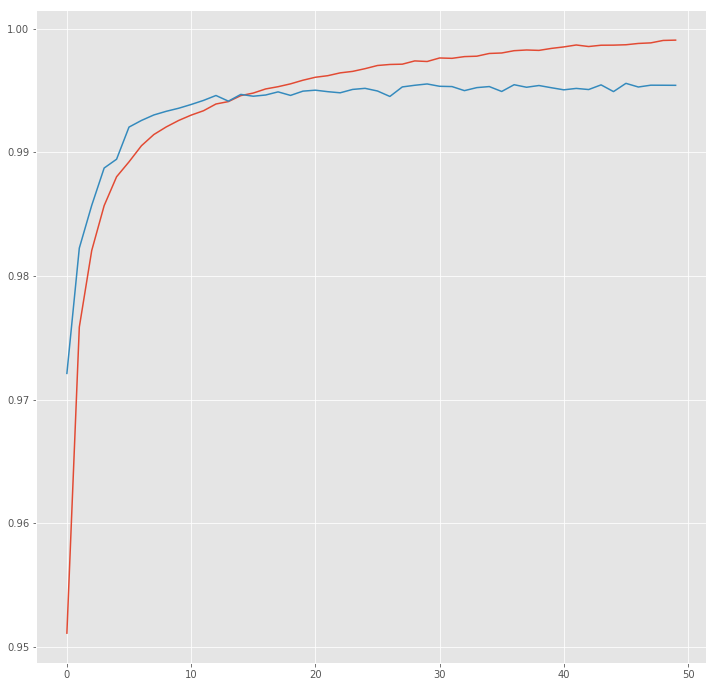

In [17]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

# Plot Loss Graph

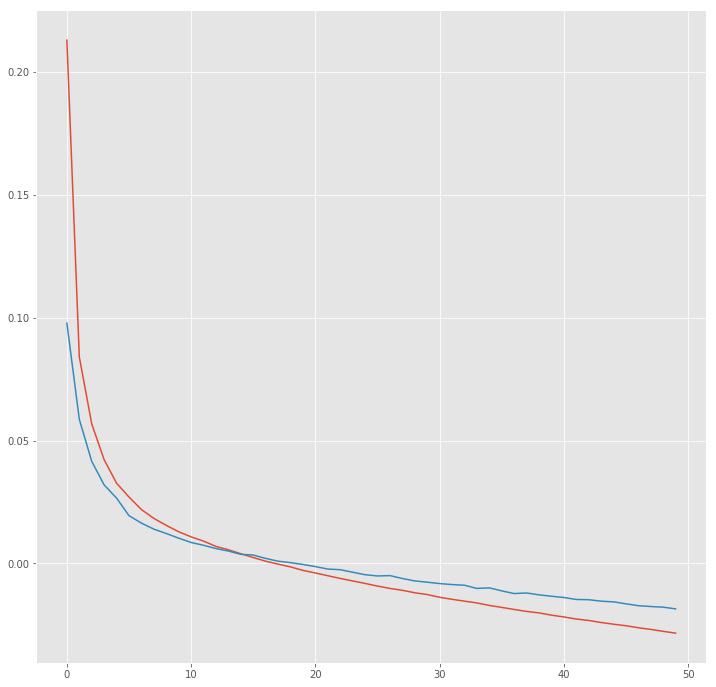

In [18]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

## Save Last Weight Model

In [19]:
save_filepath=MODEL_PATH+"last_weight-50.hdf5"
model.save_weights(save_filepath)

## Load Weight Model

In [20]:
load_filepath=MODEL_PATH+"weights-improvement-46-0.996.hdf5"
model.load_weights(load_filepath)

# Prediction

In [21]:
pred_model = model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te),max_len, max_len_char))], verbose=1)

1230/1230 [==============================] - 8s 7ms/step


In [22]:
y_pred = []
y_true = []

for i in range(0,len(pred_model)):
    try:
        out = np.argmax(pred_model[i], axis=-1)
        true = np.argmax(y_te[i], axis=-1)
        revert_pred=[ix_to_ner[i] for i in out]
        revert_true=[ix_to_ner[i] for i in true]
        y_pred.append(revert_pred)
        y_true.append(revert_true)
    except:
        print (i)

In [23]:
def ner_classification_report(y_true, y_pred):
 
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = list(sorted(set(lb.classes_)))
    tagset = tagset[:-2]
    print(tagset)
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
        digits=4
    )

In [24]:
print(ner_classification_report(y_true,y_pred))

['B-DATE', 'B-EMAIL', 'B-LAW', 'B-LEN', 'B-LOCATION', 'B-MONEY', 'B-ORGANIZATION', 'B-PERCENT', 'B-PERSON', 'B-PHONE', 'B-TIME', 'B-URL', 'B-ZIP', 'I-DATE', 'I-EMAIL', 'I-LAW', 'I-LEN', 'I-LOCATION', 'I-MONEY', 'I-ORGANIZATION', 'I-PERCENT', 'I-PERSON', 'I-PHONE', 'I-TIME', 'I-URL']
                precision    recall  f1-score   support

        B-DATE     0.9558    0.9177    0.9364       401
       B-EMAIL     1.0000    1.0000    1.0000         1
         B-LAW     0.6667    0.7200    0.6923        25
         B-LEN     0.8077    0.9545    0.8750        22
    B-LOCATION     0.8891    0.8971    0.8931       894
       B-MONEY     0.9771    0.9624    0.9697       133
B-ORGANIZATION     0.8958    0.8966    0.8962      1064
     B-PERCENT     0.9429    0.9167    0.9296        36
      B-PERSON     0.9479    0.9353    0.9416       603
       B-PHONE     0.8333    0.9375    0.8824        16
        B-TIME     0.8316    0.8956    0.8624       182
         B-URL     1.0000    0.9545    0.97

/home/suphanut_thattinaphanich/anaconda3/envs/ulmfit_venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/suphanut_thattinaphanich/anaconda3/envs/ulmfit_venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
